# Tutorial - Using CRISPRzip

This notebook gives a basic idea how the CRISPRzip model is structured and how it can be used to make predictions about Cas9 activity.


## 1. Generate R-loop landscapes
### 1.1 Specify protospacer and targets
Let's say you use CRISPR-Cas9 to target the sequence `5'-GACGCATAAAGATGAGACGCTGG-3'` and want to understand its dynamics on the on-target and on some potential off-targets. We specify them below.

In [1]:
guide_rna   =   "GACGCATAAAGATGAGACGC"     # 5'-to-3'
protospacer =  "AGACGCATAAAGATGAGACGCTGG"  # 5'-to-3', with 5' flanking NT (optional) and 3' PAM (NGG)

targets     = [protospacer,                 # on-target
               "AGACCCATTAAGATGAGACGCGGG",  # off-target 1: A13T G17C      (GGG PAM)
               "AGACGCATAACTATGAGACGCAGG",  # off-target 2: G10T A11C      (AGG PAM)
               "AGTCGCATAAAGATGAGACGCGGG",  # off-target 3: A19T           (GGG PAM)
               "AGACGCATAAAGATAAGCGGCCGG"]  # off-target 4: C03G A04C G07A (CGG PAM)

### 1.2 Choose a parameter set
#### 1.2.1 Sequence-averaged model
In CRISPRzip, you simulate the dynamics by constructing an energy landscape of the R-loop formation process. For this, we need to choose a parameter set that contains all the energy contributions. To start, let's use a simpler version of the model that only considers the positions of mismatches (without sequence content).

In [2]:
# loading a parameter set for the energy landscape model
import json
with open('../data/landscapes/average_params.json', 'r') as file:
    average_params = json.load(file)

# the Searcher object defines the energy landscapes
from crisprzip.kinetics import *
protein = Searcher(**average_params)

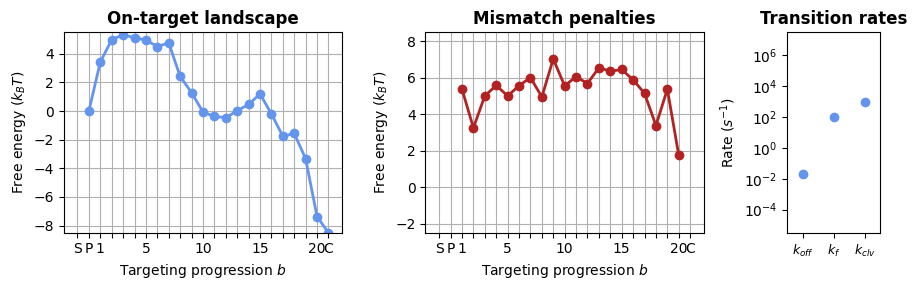

In [3]:
# visualizing the parameter set
import matplotlib.pyplot as plt
from crisprzip.plotting import SearcherPlotter

_, axes = plt.subplots(1, 3, figsize=(9, 3), width_ratios=(3, 3, 1))
SearcherPlotter(protein).plot_on_target_landscape(axs=axes[0], y_lims=(-8, 5))
SearcherPlotter(protein).plot_mismatch_penalties(axs=axes[1], y_lims=(-2, 8))
SearcherPlotter(protein).plot_internal_rates(axs=axes[2], y_lims = (1E-5, 1E7))
plt.tight_layout()

With the above parameter sets, we can construct the energy landscape for any target by adding the appropriate mismatch penalties to the on-target landscape. The SearcherTargetComplex object generates off-target landscapes - and can do calculations on the basis of these, which we'll get to in section [3](#).

In [4]:
protein_target_complexes = []
for target_seq in targets:
    mm_pattern = (GuideTargetHybrid
                  .from_cas9_offtarget(target_seq, protospacer)
                  .get_mismatch_pattern())
    protein_target_complexes += [protein.probe_target(mm_pattern)]

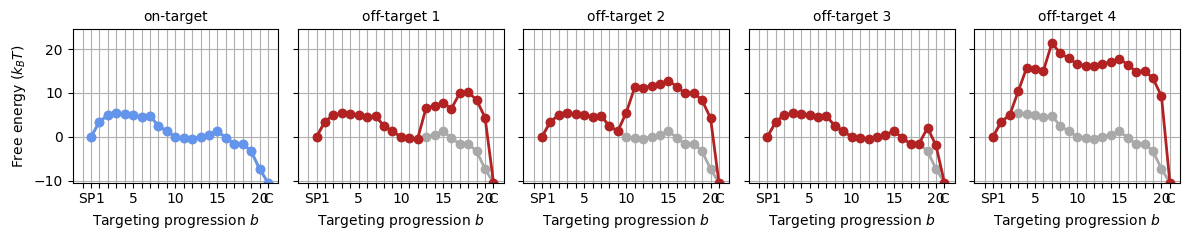

In [5]:
_, axes = plt.subplots(1, 5, figsize=(12, 2.5), sharey='all')
for i, ptc in enumerate(protein_target_complexes):
    SearcherPlotter(ptc).plot_off_target_landscape(axs=axes[i], y_lims=(-10, 24))

    if i == 0:
        axes[i].get_lines()[1].set_color('cornflowerblue')
        axes[i].set_title('on-target', fontsize='medium')
    else:
        axes[i].set_ylabel('')
        axes[i].set_title(f"off-target {i:d}", fontsize='medium')

plt.tight_layout()

For clarity, the 'mismatch patterns' that the above landscapes are based on relate to the gRNA and target sequence as follows.

In [6]:
hybrid = GuideTargetHybrid.from_cas9_offtarget(targets[1], protospacer)
hybrid.set_rloop_state(20)
print("\n".join([
    'R-loop visualization:',
    '',
    str(hybrid),
    '',
    f"Mismatch pattern: {str(hybrid.get_mismatch_pattern())}  (3'-to-5')",
]))

R-loop visualization:

 5'-GACGCAUAAAGAUGAGACGC-3'  (RNA guide)
    |||·|||·||||||||||||
3'-TCTGGGTAATTCTACTCTGCGC-5' (DNA TS)
   |                    |
5'-AGACCCATTAAGATGAGACGCG-3' (DNA NTS)
    20   15   10   5   1

Mismatch pattern: 00000000000010001000  (3'-to-5')


#### 1.2.2 Sequence-specific model
CRISPRzip can consider the sequence of the gRNA and target into account when calculating off-target landscapes. Using a sequence-specific model will give different activity predictions for off-targets that have the same mismatch pattern but a different sequence (e.g. A04T vs A04G).

The off-target landscapes will not only include the energy contributions from the protein (internal stability, NA backbone interactions), but will add the expected free energy cost of the R-loop. This R-loop cost is calculated in the module `nucleic_acid.py`. To support this addition of the R-loop cost, we should switch from the 'Searcher' and 'SearcherTargetComplex' object to a 'BareSearcher', 'GuidedSearcher' and 'SearcherSeqeunceComplex', as they add this energy in the calculation of the off-target landscape.

In [7]:
# loading a parameter set for the energy landscape model
import json
with open('../data/landscapes/sequence_params.json', 'r') as file:
    sequence_params = json.load(file)

# the BareSearcher object defines the energy landscapes
from crisprzip.kinetics import *
bare_protein = BareSearcher(**sequence_params)
# the GuidedSearcher has an attribute for the protospacer, reflecting the gRNA loading
guided_protein = GuidedSearcher(**sequence_params, protospacer=protospacer)

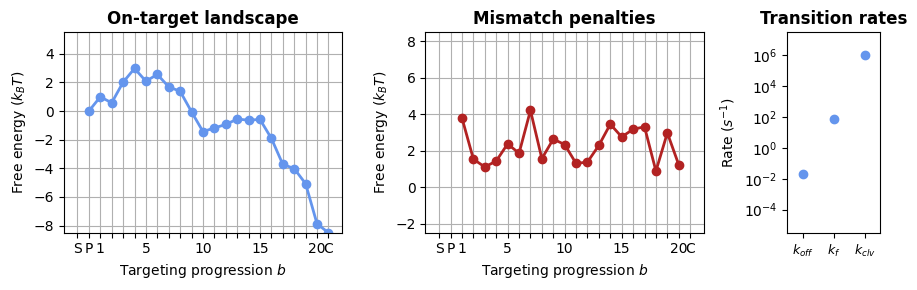

In [8]:
# visualizing the parameter set
import matplotlib.pyplot as plt
from crisprzip.plotting import SearcherPlotter

_, axes = plt.subplots(1, 3, figsize=(9, 3), width_ratios=(3, 3, 1))
SearcherPlotter(bare_protein).plot_on_target_landscape(axs=axes[0], y_lims=(-8, 5))
SearcherPlotter(bare_protein).plot_mismatch_penalties(axs=axes[1], y_lims=(-2, 8))
SearcherPlotter(bare_protein).plot_internal_rates(axs=axes[2], y_lims = (1E-5, 1E7))
plt.tight_layout()

These landscapes clearly differ from those in the sequence-averaged model! The difference is that these are only the protein contributions; when the R-loop cost is added below, these landscapes will look a lot more similar to those above.

Again, we construct the energy landscape for various targets. The 'ProteinSequenceComplex' takes the off-target _sequences_ as an input, and handles the addition of the R-loop cost, and apart from that, it is identical to the (sequence-independent) 'ProteinTargetComplex'.

In [9]:
protein_sequence_complexes = []
for target_seq in targets:
    protein_sequence_complexes += [guided_protein.probe_sequence(target_seq)]

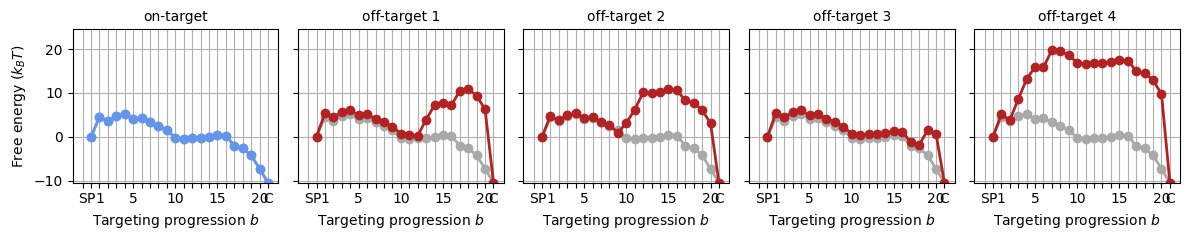

In [10]:
_, axes = plt.subplots(1, 5, figsize=(12, 2.5), sharey='all')
for i, psc in enumerate(protein_sequence_complexes):
    SearcherPlotter(psc).plot_off_target_landscape(axs=axes[i], y_lims=(-10, 24))

    if i == 0:
        axes[i].get_lines()[1].set_color('cornflowerblue')
        axes[i].set_title('on-target', fontsize='medium')
    else:
        axes[i].set_ylabel('')
        axes[i].set_title(f"off-target {i:d}", fontsize='medium')

plt.tight_layout()

These landscapes are very similar to the landscapes generated by the sequence-averaged model, however, there are small deviations as a result of the base contents. We'll stick by these landscapes in the tutorial from here on.

### Next steps:
- show cleavage plot
  - fclv vs time (different concs)
  - kclv vs conc
- show binding plot
  - fbnd vs time (different concs)
  - K vs conc

In [11]:
# loading a parameter set for the energy landscape model
with open('../../data/landscapes/average_params.json', 'r') as file:
    average_params = json.load(file)

protein = Searcher(**bare_protein_params)
guided_protein = bare_protein.bind_guide_rna(protospacer)
protein_target_complexes = [guided_protein.probe_sequence(target_seq)
                            for target_seq in targets]

FileNotFoundError: [Errno 2] No such file or directory: '../../data/landscapes/average_params.json'

In [ ]:
# visualizing the parameter set that defines the energy model
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(9, 3), width_ratios=(3, 3, 1))
SearcherPlotter(bare_protein).plot_on_target_landscape(axs=axes[0], y_lims=(-8, 5))
SearcherPlotter(bare_protein).plot_mismatch_penalties(axs=axes[1], y_lims=(-2, 8))
SearcherPlotter(bare_protein).plot_internal_rates(axs=axes[2], y_lims = (1E-5, 1E7))
plt.tight_layout()

## Predicting cleavage rates
With this functionality, a user can predict the probability that a DNA sequence is cleaved. This depends both on concentration and on exposure time, so these parameters could be implemented as an interactive slider. Also, I could calculate the cleavage vs time curve and plot that for an individual or for a few DNA targets.

In [ ]:
k_on_ref = 1E-2  # default parameter: k_on at 1 nM (Hz)

# user input
concentration = 5  # nM
time = 600 # s (= 10 mins)

binding_rate = k_on_ref * concentration
f_clv = [stc.get_cleaved_fraction(time, binding_rate)
         for stc in protein_target_complexes]


In [ ]:
_, axs_clv = plt.subplots(1, 1, figsize=(4, 3))
axs_clv.bar(np.arange(len(protein_target_complexes)),
        np.array(f_clv) * 100, .8)
axs_clv.set_xlabel("Off-target no.")
axs_clv.set_ylabel(r"$p_{cut}$ (%)")
plt.show()

## Predicting binding constants
With this functionality, a user can predict the probability that a DNA sequence is bound. This depends strongly on concentration (and somewhat on exposure time), so these parameters could be implemented as an interactive slider.

In [ ]:
# user input
concentration = 5  # nM
time = 600 # s (= 10 mins)

binding_rate = k_on_ref * concentration
f_bnd = [stc.get_bound_fraction(time, binding_rate)
         for stc in protein_target_complexes]


In [ ]:
_, axs_bnd = plt.subplots(1, 1, figsize=(4, 3))
axs_bnd.bar(np.arange(len(protein_target_complexes)),
        np.array(f_bnd) * 100, .8)
axs_bnd.set_xlabel("Off-target no.")
axs_bnd.set_ylabel(r"$p_{bound}$ (%)")
plt.show()

## Other
There are a few other features I could add relatively easily:
- Visualizing the energy landscape of a protein-target complex
- Visualizing a coarse-grained version of the full energy landscape
- Generating cleavage and binding curves as a function of time and concentration
- Doing statistics on the cleavage/binding characteristics of the off-target sequences (tables, histograms, etc.)